# Loading and playing with Sentinel-2 imagery data



In [1]:
%matplotlib notebook

import xray
import rasterio
from glob import glob
from soda.utils.maptools import readraster
import matplotlib.pyplot as plt


from scipy.ndimage import gaussian_filter
import numpy as np

In [2]:
#sardir='/home/suntans/Share/ARCHub/DATA/REMOTE/Glovis/S2A_OPER_PRD_MSIL1C_PDMC_20161105T111512_R017_V20161105T020442_20161105T020442.SAFE/GRANULE/S2A_OPER_MSI_L1C_TL_SGS__20161105T085105_A007164_T51LWE_N02.04/IMG_DATA/'
#sardir = r'/home/suntans/Share/ARCHub/DATA/REMOTE/Glovis/S2A_OPER_PRD_MSIL1C_PDMC_20161118T124512_R060_V20161118T021342_20161118T021342.SAFE/GRANULE/S2A_OPER_MSI_L1C_TL_SGS__20161118T085740_A007350_T50KPE_N02.04/IMG_DATA'
#sardir = r'/home/suntans/Share/ARCHub/DATA/REMOTE/Glovis/RowleyScenes/'
sardir = r'/home/suntans/Share/ARCHub/DATA/REMOTE/Glovis/BrowseScenes/'


sarfiles = glob('%s/*.jp2'%sardir)
sarfile = sarfiles[1]
print sarfile


/home/suntans/Share/ARCHub/DATA/REMOTE/Glovis/BrowseScenes/T51LWE_20170524T020751_B02.jp2


In [3]:
ds = xray.open_rasterio(sarfile)

/home/suntans/anaconda/envs/suntans/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The value of this property will change in version 1.0. Please see https://github.com/mapbox/rasterio/issues/86 for details.
  """Entry point for launching an IPython kernel.


In [4]:
ds

<xarray.DataArray (band: 1, y: 10980, x: 10980)>
[120560400 values with dtype=uint16]
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 8.5e+06 8.5e+06 8.5e+06 8.5e+06 8.5e+06 8.5e+06 ...
  * x        (x) float64 5e+05 5e+05 5e+05 5e+05 5e+05 5e+05 5e+05 5.001e+05 ...
Attributes:
    crs:        +init=epsg:32751
    transform:  (499980.0, 10.0, 0.0, 8500000.0, 0.0, -10.0)
    is_tiled:   1
    res:        (10.0, 10.0)

In [5]:
# Use xarray (faster read)
#ds.load()
#data = ds[0,::1,::1].values.astype(np.float)
#dx = np.diff(ds.x[::1]).mean()

#ds.to_netcdf(outfile, format='NETCDF4_CLASSIC', engine='netcdf4')
#ds.to_netcdf(outfile)

# Use rasterio
ds = rasterio.open(sarfile)
_,dx,_,_,_,dy = ds.transform
data = ds.read(1).astype(np.float)

# Subsample
#dx *=2
#data = data[::2,::2].astype(np.float)
#data.shape


/home/suntans/anaconda/envs/suntans/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2881: FutureWarning: The value of this property will change in version 1.0. Please see https://github.com/mapbox/rasterio/issues/86 for details.
  exec(code_obj, self.user_global_ns, self.user_ns)


<IPython.core.display.Javascript object>


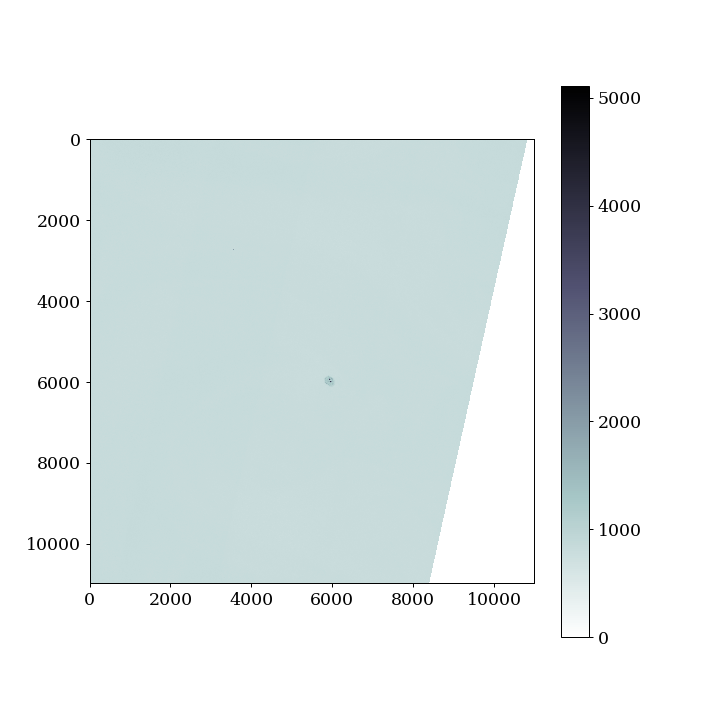

In [6]:
plt.figure(figsize=(8,8))
plt.imshow(data, cmap='bone_r')
plt.colorbar()
plt.show()

In [7]:
# Band pass filter the image using a gaussian filter
filtwidth=5000.
filtwidth2 = 50.

sigma = filtwidth/dx
print 'Filtering dx = %f...'%filtwidth
datal = gaussian_filter(data, sigma)

datah = data - datal

print datal.shape, data.shape
del data 
del datal

# Bandpass to remove short wavelengths
sigma = filtwidth2/dx
print 'Filtering dx = %f...'%filtwidth2
datab = gaussian_filter(datah, sigma)
databmax = datab.max()

Filtering dx = 5000.000000...
(10980, 10980) (10980, 10980)
Filtering dx = 50.000000...


<IPython.core.display.Javascript object>


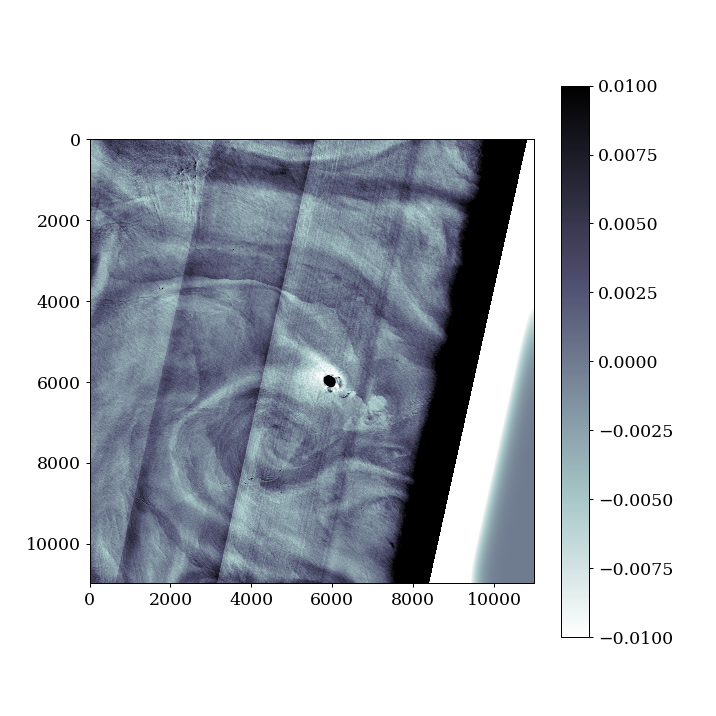

In [8]:
plt.figure(figsize=(8,8))
plt.imshow(datab/databmax, cmap='bone_r', vmin=-0.01, vmax=0.01)
plt.colorbar()
plt.show()


In [9]:
outfile = '%s/test_browse_may11.tif'%sardir
# Save the filtered quantity to a raster (tiff)
profile = ds.profile

profile['driver'] = 'GTiff'

outdata = np.zeros((1,datab.shape[0],datab.shape[1]), 'uint16')
outdata[0,...] = np.ceil(datab - datab.min())

print 'Writing...'
# Write to tif, using the same profile as the source
with rasterio.open(outfile, 'w', **profile) as dst:
    dst.write(outdata)

print 'saved to %s'%outfile

Writing...


/home/suntans/anaconda/envs/suntans/lib/python2.7/site-packages/rasterio/__init__.py:160: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  transform = guard_transform(transform)


saved to /home/suntans/Share/ARCHub/DATA/REMOTE/Glovis/BrowseScenes//test_browse_may11.tif


In [10]:
np.array((0.1)).astype('uint16')


array(0, dtype=uint16)